# Code

In [1]:
# import libraries
library(readxl)
library(timedeppar)

Loading required package: mvtnorm



In [2]:
# import datasets
col_names <- c("Year1", "Cycle1", "blank1", "Year2", 
               "Cycle2", "blank2", "Year3", "Cycle3")
df <- read_excel("./data/syntheticData.xlsx", skip=4, 
                 col_names=col_names)
df1 <- df[,c(1,2)]
df2 <- df[,c(4,5)]
df3 <- df[,c(7,8)]

In [3]:
# log-likelihood function
loglikeli <- function(param, data) {
    # build time series from intervals
    xi <- param$xi[,2]
    t0 <- data[[1,1]]
    t <- c(t0, t0+cumsum(xi))
    
    
    # model parameters
    A <- param$A
    period <- 11 # years
    omega <- 2 * pi / period
    phi <- param$phi
    
    # harmonic signal at inferred time points
    y_model <- A * cos(omega * t + phi)
    
    # log-likelihood of observed data
    loglik <- sum(dnorm(data[[2]], mean=y_model,
                        sd=param$sigma_y, log=TRUE))
    
    # feedback
    count <<- count + 1
    current_percent <- as.integer(100*count/max_count)
    if (current_percent > percent) {
        percent <<- current_percent
        # draw percent bar
        filled <- floor(percent / 2)
        bar <- c(
            rep("=", filled),
            ">",
            rep(" ", 50 - filled - 1),
            "]"
        )
        # bar <- paste(rep("=", percent), collapse="")
        #cat("\r[", bar, ">", "]\t", percent, "%", sep="")
        cat(paste0("\r[", paste(bar, collapse = ""), "  ", current_percent, "%"))
        
        flush.console()
    }

    return(loglik)
}

# initialization parameters function
initialize_params <- function(data, A=1, phi=0, sigma_y=0.1, 
                              xi_mean=1, xi_sd=0.1, xi_gamma=10) {
    
    times <- data[[1]][1:(nrow(data)-1)]
    
    # initial parameters for the harmonic model
    xi_init <- randOU(
        mean = xi_mean,
        sd = xi_sd,
        gamma = xi_gamma,
        t = times
    )
    xi_matrix <- as.matrix(cbind(times, xi_init$y))
    
    param.ini <- list(
        xi = xi_matrix,
        A = A,
        phi = phi,
        sigma_y = sigma_y
    )
    
    # initial parameters for OU processes (xi) 
    param.ou.ini = c(
        xi_mean = xi_mean,
        xi_sd = xi_sd,
        xi_gamma = xi_gamma
    )
    
    return(list(param.ini=param.ini, param.ou.ini=param.ou.ini))
}

# inference function
run_inference <- function(data, param.ini, param.ou.ini,
                         n.iter=1000, n.interval=50, n.adapt=NA) {
    
    if (!is.numeric(n.adapt)) {
        n.adapt <- 0.4 * n.iter
    }
    
    res <- infer.timedeppar(
        loglikeli = loglikeli,
        data = data,
        param.ini = param.ini,
        param.ou.ini = param.ou.ini,
        param.range = list(
            A = c(1, 10),
            phi = c(0, 2*pi),
            sigma_y = c(0.01, 10),
            xi = c(0.1, 2),
            xi_mean = c(-10, 10),
            xi_sd = c(0.01, 10),
            xi_gamma = c(1, 20)
        ),
        param.log = c(
            A = FALSE,
            phi = FALSE,
            sigma_y = TRUE,
            xi = TRUE
        ),
        n.iter = n.iter,
        control = list(
            n.interval = n.interval,
            n.adapt = n.adapt
        ),
        verbose = 0
    )
}

infer.timedeppar (timedeppar 1.0.3 2023-08-28): starting new Markov Chain

  number of constant parameters:          3

  number of time-dependent parameters:    1

  number of estimated process parameters: 3



[>                                                 ]  1%[1] 0
[=>                                                ]  2%[1] 0
[=>                                                ]  3%[1] 0
[==>                                               ]  4%[1] 0
[==>                                               ]  5%[1] 0
[===>                                              ]  6%[1] 0
[===>                                              ]  7%[1] 0
[====>                                             ]  8%[1] 0
[====>                                             ]  9%[1] 0
[=====>                                            ]  10%[1] 0
[=====>                                            ]  11%[1] 0
[======>                                           ]  12%[1] 0
[======>                                           ]  13%[1] 0.04094679
[=======>                                          ]  14%[1] 0.04094679
[=======>                                          ]  15%[1] 0.04094679
[========>                           

100 iterations completed

  acceptance frequency of constant parameters:             0.5

  acceptance frequencies of time-dependent parameters:     0.0447

  acceptance frequencies of Ornstein-Uhlenbeck parameters: 0.0833

plot.timedeppar (timedeppar 1.0.3 2023-08-28): plotting inference results: traces,marginals,summary,pairs,time-series,accept



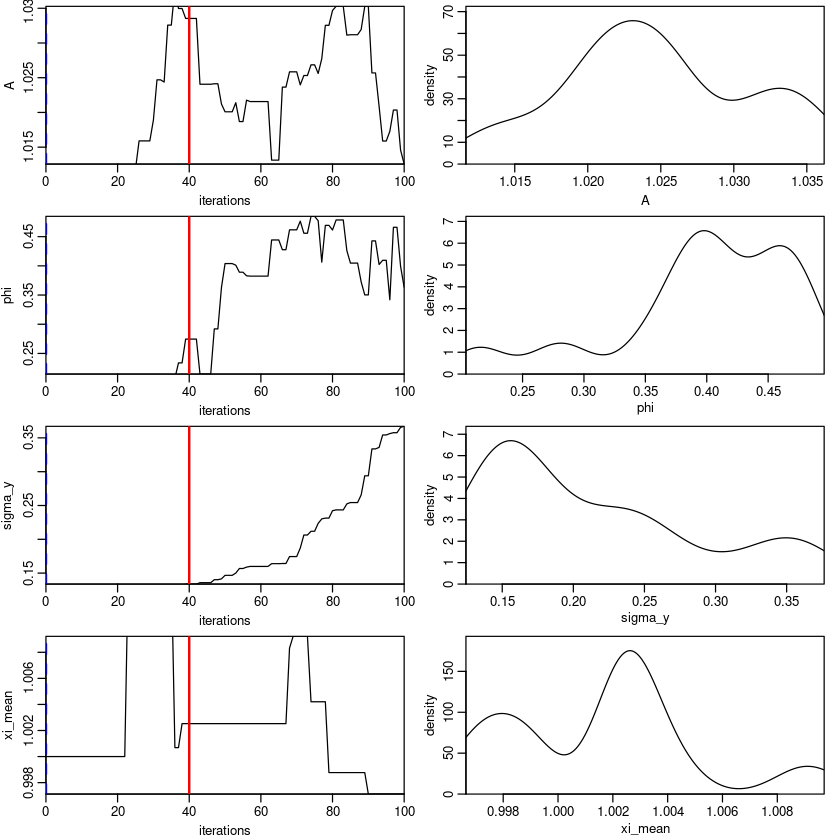

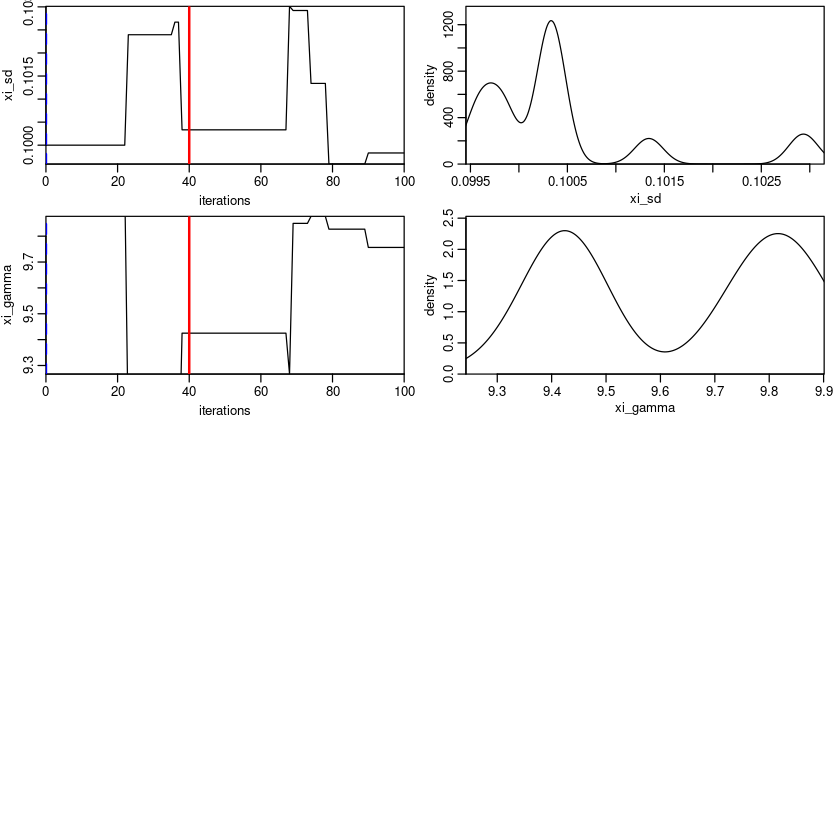

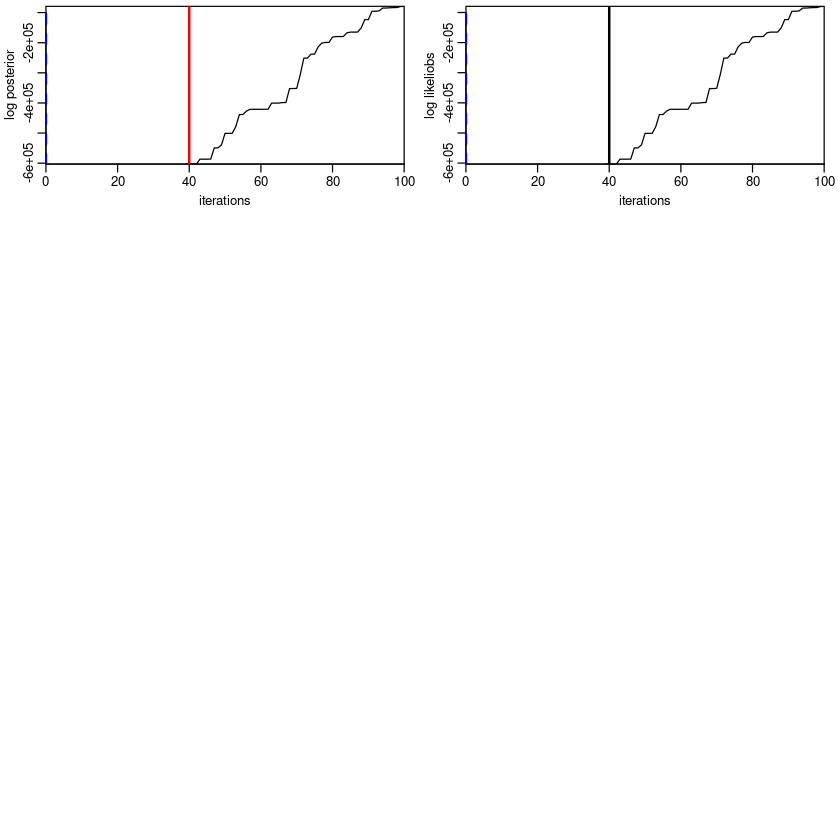

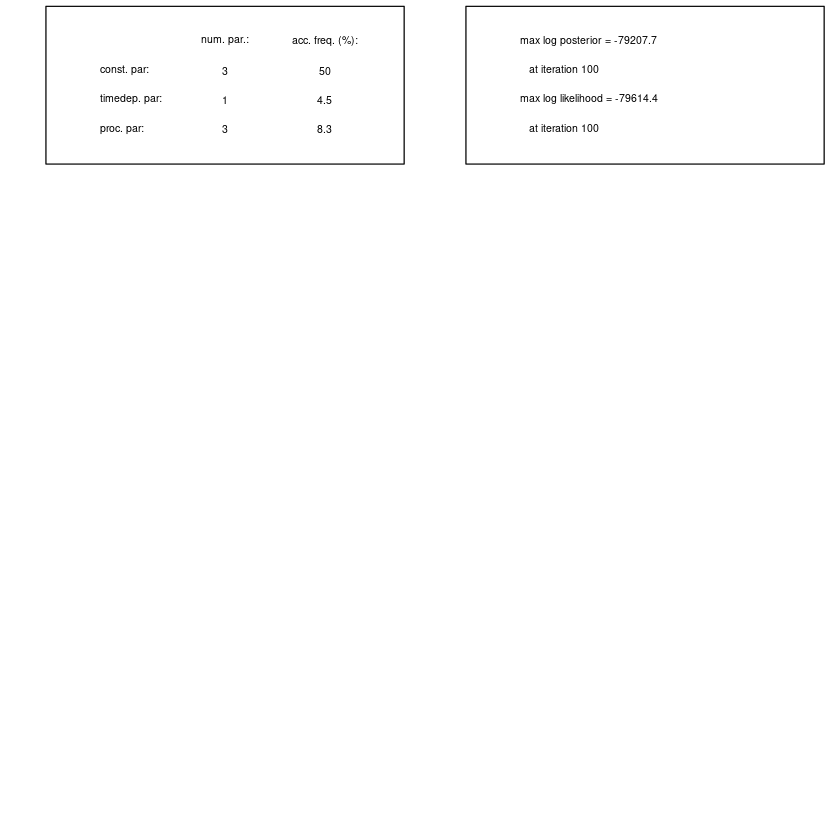

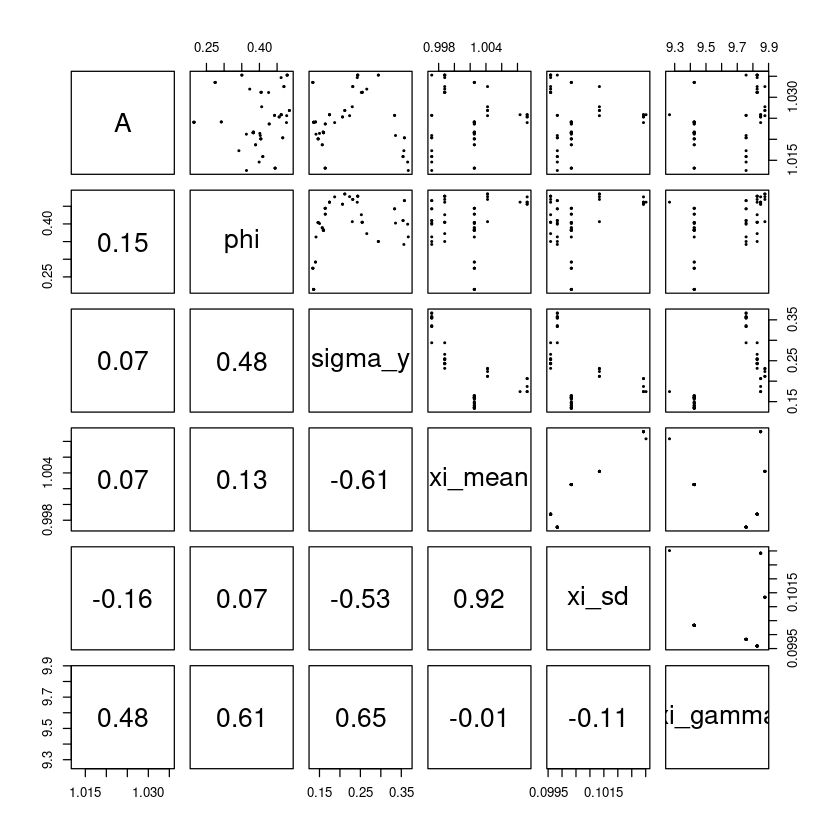

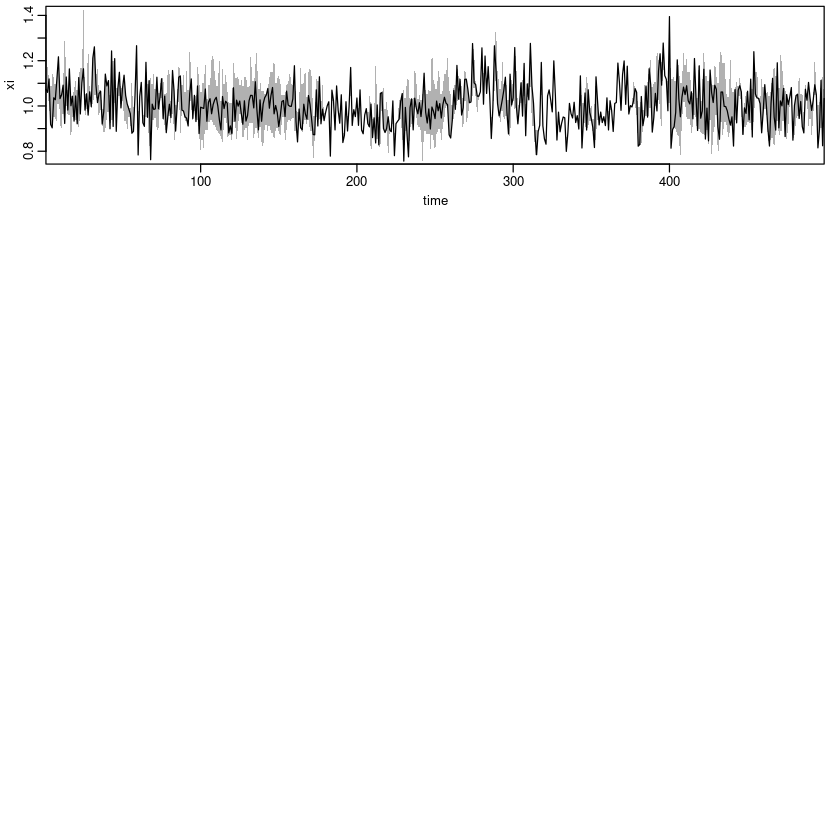

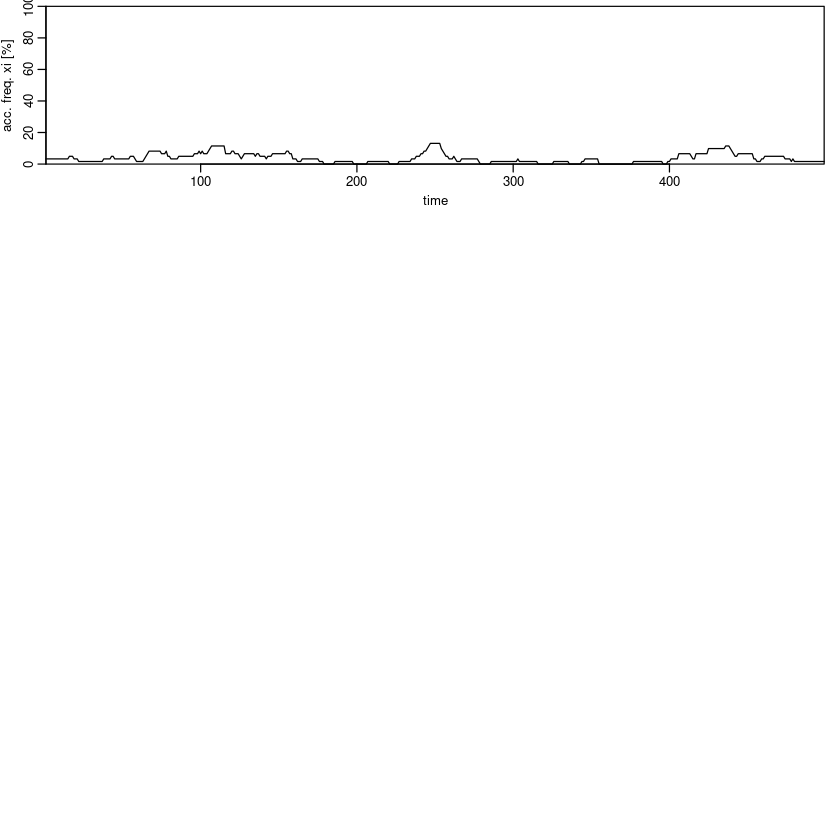

In [4]:
count <- 0
percent <- 0
n_iter <- 100
n_interval <- 25
n_adapt <- 0.4 * n_iter
max_count <- n_iter * (n_interval + 1)
data = df3

params <- initialize_params(
    data,
    xi_sd = 0.1,
    xi_gamma = 10
)
res <- run_inference(
    data,
    params$param.ini, 
    params$param.ou.ini,
    n.iter = n_iter,
    n.interval = n_interval,
    n.adapt = n_adapt
)
plot(res)

In [5]:
res

$package
[1] "timedeppar 1.0.3 2023-08-28"

$func
[1] "infer.timedeppar"

$date
[1] "2025-05-11"

$dot.args
$dot.args$data
# A tibble: 500 × 2
   Year3 Cycle3
   <dbl>  <dbl>
 1     1  -8.42
 2     2 -10   
 3     3  -8.41
 4     4  -4.15
 5     5   1.43
 6     6   6.55
 7     7   9.60
 8     8   9.59
 9     9   6.54
10    10   1.42
# ℹ 490 more rows


$task
[1] "start"

$file
[1] ""

$param.ini
$param.ini$xi
       times          
  [1,]     1 0.8429707
  [2,]     2 0.9003778
  [3,]     3 1.0468257
  [4,]     4 1.1650542
  [5,]     5 1.0485956
  [6,]     6 0.8898752
  [7,]     7 0.9609985
  [8,]     8 0.8839352
  [9,]     9 0.8877450
 [10,]    10 0.9885004
 [11,]    11 0.9592296
 [12,]    12 1.0514110
 [13,]    13 0.9944644
 [14,]    14 0.9981991
 [15,]    15 1.0163935
 [16,]    16 1.0154125
 [17,]    17 0.9585373
 [18,]    18 0.9787051
 [19,]    19 1.1031213
 [20,]    20 0.9917900
 [21,]    21 1.0995404
 [22,]    22 0.9749074
 [23,]    23 0.9951409
 [24,]    24 1.0181205
 [25,]    25

# Outputs

In [6]:
# res$sample.param.timedep$xi
# res$sample.param.ou
# res$sample.param.const
# res$sample.logpdf